## click-throught rate 分析報告

In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import os
sns.set()
path_raw_data = '../raw_data'

## ０. 讀取資料：查看資料樣本大小，變數型態、意義

In [2]:
#訓練集:按時間排序的十天廣告點擊資料，共40428967筆
#測試集:按時間排序的一天廣告點擊資料，共4577464筆
train = pd.read_csv(os.path.join(path_raw_data, 'train.csv'), nrows = 10000000)
train.head(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1000000 non-null  float64
 1   click             1000000 non-null  int64  
 2   hour              1000000 non-null  int64  
 3   C1                1000000 non-null  int64  
 4   banner_pos        1000000 non-null  int64  
 5   site_id           1000000 non-null  object 
 6   site_domain       1000000 non-null  object 
 7   site_category     1000000 non-null  object 
 8   app_id            1000000 non-null  object 
 9   app_domain        1000000 non-null  object 
 10  app_category      1000000 non-null  object 
 11  device_id         1000000 non-null  object 
 12  device_ip         1000000 non-null  object 
 13  device_model      1000000 non-null  object 
 14  device_type       1000000 non-null  int64  
 15  device_conn_type  1000000 non-null  int64  
 16  C

### 變量名稱:
* id: 用戶ID號(float 20位數)
* click: 0/1 表示未點擊/點擊(int)
* hour: 格式YYMMDDHH，14102100為2014年10月21日時間00:00(int)
* C1: 匿名分類變量(int 4位數)
* banner_pos: 網頁上的廣告位置(0,1,2..)
* site_id:網點ID
* site_domain:網點領域
* site_category: 網點類別
* app_id:用戶APP的ID
* app_domain:app區域
* app_category:app類別
* device_id: 設備編號
* device_ip:設備ip位置
* device_model:設備模型(int)
* device_type: 設備類型(int)
* device_conn_type:設備接入類型(int)
* C14-C21 :匿名類別變量(int)

In [4]:
train.columns #變數名稱

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [5]:
train.shape #資料筆數、變數個數

(1000000, 24)

In [6]:
#del train
train = pd.read_csv(os.path.join(path_raw_data, 'train.csv'), nrows = 1000000)
train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


 * 看是否需要進行補值 

In [7]:
##查看缺失值情況，(各欄位皆無NULL，資料完整)
train.isnull().any()  

id                  False
click               False
hour                False
C1                  False
banner_pos          False
site_id             False
site_domain         False
site_category       False
app_id              False
app_domain          False
app_category        False
device_id           False
device_ip           False
device_model        False
device_type         False
device_conn_type    False
C14                 False
C15                 False
C16                 False
C17                 False
C18                 False
C19                 False
C20                 False
C21                 False
dtype: bool

In [8]:
train.describe() #各變數的最大值、最小值、平均值、標準差、個數、四分位數

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000000e+06,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,9.376314e+18,0.160219,1.410210e+07,1005.088166,0.229922,1.025540,0.223363,18262.203151,318.965808,56.495546,2041.031112,1.452262,190.779388,45505.857239,69.936118
std,5.236908e+18,0.366809,1.493256e+00,1.156928,0.464627,0.453899,0.667164,3510.366302,19.452897,36.546944,441.200965,1.362637,273.439286,49843.810147,38.513846
min,9.984920e+12,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,4.846660e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,15707.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,43.000000
50%,9.834387e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,19251.000000,320.000000,50.000000,2161.000000,1.000000,39.000000,-1.000000,61.000000
75%,1.373053e+19,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,21153.000000,320.000000,50.000000,2420.000000,3.000000,297.000000,100084.000000,79.000000
max,1.844670e+19,1.000000,1.410210e+07,1012.000000,7.000000,5.000000,5.000000,21705.000000,1024.000000,1024.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000


## 1. EDA 探索性資料分析

<function matplotlib.pyplot.show(*args, **kw)>

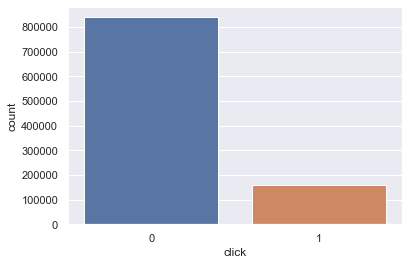

In [9]:
sns.countplot(train['click']) #是屬於一種不平衡資料
plt.show

In [10]:
#"不會點擊的人數"是"會點擊的人數"的5.2倍，也就是六個人裡，有五個不會click、一個人會click
train.groupby(['click']).count()['id'][0]/train.groupby(['click']).count()['id'][1]

5.241457005723416

<function matplotlib.pyplot.show(*args, **kw)>

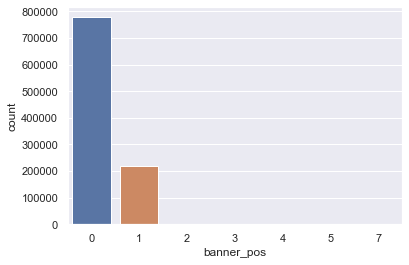

In [11]:
sns.countplot(train.banner_pos) #廣告位置分布，主要於0跟1
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

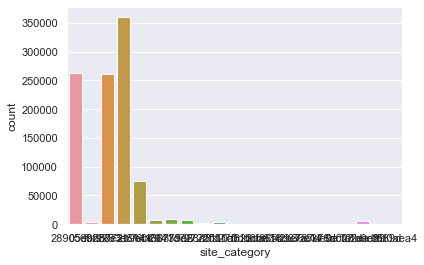

In [12]:
sns.countplot(train.site_category) #公司廣告類型主要四種佔大宗
plt.show

In [13]:
#網點類別共21種，其中50e219e0出現36萬次、28905ebd/f028772b皆出現26萬次
from collections import Counter
counts = Counter(train['site_category'])
counts 

Counter({'28905ebd': 262519,
         '0569f928': 4505,
         'f028772b': 260471,
         '50e219e0': 360056,
         '3e814130': 75062,
         '76b2941d': 7880,
         'f66779e6': 8842,
         '335d28a8': 7251,
         '72722551': 2705,
         '75fa27f6': 3958,
         '110ab22d': 1,
         'c0dd3be3': 552,
         'bcf865d9': 25,
         'a818d37a': 374,
         '42a36e14': 13,
         'e787de0e': 281,
         '5378d028': 10,
         '9ccfa2ea': 4,
         '70fb0e29': 4961,
         'dedf689d': 508,
         '8fd0aea4': 22})

In [14]:
##top3 位置類別分別為 50e219e0 28905ebd  f028772b  占了全部的88%        
train.groupby(['site_category']).count()["id"].sort_values(ascending = False)/10000

site_category
50e219e0    36.0056
28905ebd    26.2519
f028772b    26.0471
3e814130     7.5062
f66779e6     0.8842
76b2941d     0.7880
335d28a8     0.7251
70fb0e29     0.4961
0569f928     0.4505
75fa27f6     0.3958
72722551     0.2705
c0dd3be3     0.0552
dedf689d     0.0508
a818d37a     0.0374
e787de0e     0.0281
bcf865d9     0.0025
8fd0aea4     0.0022
42a36e14     0.0013
5378d028     0.0010
9ccfa2ea     0.0004
110ab22d     0.0001
Name: id, dtype: float64

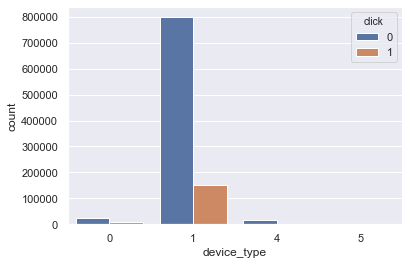

In [15]:
sns.countplot(x = "device_type", hue = "click", data = train) #客戶主要來裝置類型 1

<Figure size 1080x864 with 0 Axes>

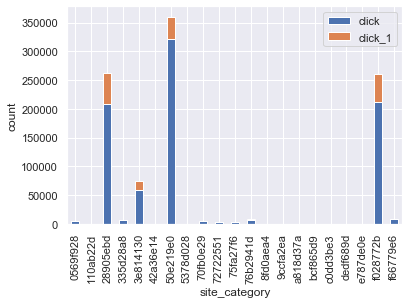

In [16]:
fig = plt.figure(figsize = (15,12))  #‘50e219e0’類廣告，點擊數與“點擊數/總數”最高。
fig.set(alpha=0.2)  

click_0 = train.site_category[train.click == 0].value_counts()
click_1 = train.site_category[train.click == 1].value_counts()

df=pd.DataFrame({'click':click_0, 'click_1':click_1})
df.plot(kind='bar', stacked=True)

plt.xlabel("site_category")
plt.ylabel("count")
plt.show()

In [17]:
train.site_id.value_counts() #counts最高爲332893 、頻率低於20的，這樣的類別，需要後續處理。

85f751fd    332893
1fbe01fe    232096
d9750ee7     38603
e151e245     32359
5b08c53b     16455
             ...  
af62ef47         1
d191be52         1
dde8c24f         1
1289c10f         1
911fd6b7         1
Name: site_id, Length: 2075, dtype: int64

In [18]:
## device_id中，a99f214a 出現頻率特別高
train.device_id.value_counts() 

a99f214a    840265
c357dbff      1310
936e92fb       482
31da1bd0       292
787d2bb0       274
             ...  
b3dea4cb         1
9b2e8d5d         1
9a3254fd         1
dec1f613         1
9ff73b11         1
Name: device_id, Length: 83431, dtype: int64

In [19]:
train.app_id.value_counts()

ecad2386    667107
e2fcccd2     32263
febd1138     24725
54c5d545     12027
9c13b419     11481
             ...  
169af9db         1
646b9844         1
418c24bc         1
887cf5d1         1
1347f073         1
Name: app_id, Length: 2309, dtype: int64

In [20]:
train.device_model.value_counts()

8a4875bd    59771
d787e91b    42206
1f0bc64f    37525
4ea23a13    19853
a0f5f879    17158
            ...  
6d79a0ad        1
d17eb896        1
eae9ef59        1
53fdbbbc        1
ffc554e9        1
Name: device_model, Length: 4581, dtype: int64

## 2. 相關性分析

* Ｌabelencoder　類別資料轉換數值型，提供後續特徵工程與建模

In [ ]:
#### C14 與 C17相關性極高，
for column in ['C1', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model']:
    enc = LabelEncoder()
    train[column] = enc.fit_transform(train[column])    
sub_train = train.iloc[:, 4:]
plt.figure(figsize=(20, 18))
sns.heatmap(sub_train.corr().abs(), annot=True)
plt.show()

In [22]:
#從原始資料，按click的比例進行分層抽樣，取出比分之五的資料量當作訓練集
from sklearn.model_selection import StratifiedShuffleSplit
train_all = train
split = StratifiedShuffleSplit(n_splits=1, train_size=0.05, random_state=42)
for train_index, test_index in split.split(train_all, train_all["click"]):
    strat_train_set = train_all.loc[train_index]
    strat_train_set.to_pickle("strat_train_set.pkl")

# 3.data preprocessing 資料預處理

In [23]:
#確認分層結果
train = strat_train_set
train.click.value_counts(),train_all.click.value_counts()

(0    41989
 1     8011
 Name: click, dtype: int64,
 0    839781
 1    160219
 Name: click, dtype: int64)

In [24]:
#反映變數click與其他變數的相關性，C16與click相關性最大
corr_matrix = train.corr()
corr_matrix["click"].sort_values(ascending = False)

click               1.000000
C16                 0.119336
app_id              0.080976
app_domain          0.037816
banner_pos          0.031366
device_id           0.027993
C19                 0.024764
site_domain         0.007183
id                  0.002797
site_category      -0.002540
device_model       -0.005318
device_ip          -0.009150
hour               -0.019493
site_id            -0.022487
C20                -0.024262
C15                -0.037354
device_type        -0.042166
device_conn_type   -0.045412
C18                -0.051038
C1                 -0.058686
C21                -0.069727
app_category       -0.076641
C17                -0.108722
C14                -0.113422
Name: click, dtype: float64

In [25]:
strat_train_set.to_csv('strat_train_set.csv')
data_type = {'id': 'U', 'hour': 'U', 'device_type':'U', 'C1':'U', 'C15':'U', 'C16':'U'}
train = pd.read_csv(os.path.join(path_raw_data, 'strat_train_set.csv'), dtype=data_type, index_col='id')
test  = pd.read_csv(os.path.join(path_raw_data, 'test.csv'), dtype=data_type, index_col='id')
test.insert(0, 'click', 0)
tr_ts = pd.concat([test, train], copy=False)

* 針對非數值資料，site_id、site_domain、app_id、device_model 將四個特徵存在許多低頻率類別

In [26]:
#網站代碼(site_id)
site_id_count = tr_ts.site_id.value_counts()
site_id_category={}
site_id_category[0] = site_id_count.loc[site_id_count>20].index.values
site_id_category[1] = site_id_count.loc[site_id_count<=20].index.values
site_id_C_type_dict = {}
for key, values in site_id_category.items():
    for item in values:
        site_id_C_type_dict[str(item)] = key
json.dump(site_id_C_type_dict, open("site_id_C_type_dict.json", "w"))

In [27]:
tr_ts.head(5)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,Unnamed: 0
id,,,,,,,,,,,,,,,,,,,,,
1.000017e+19,0,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,0,8330,320,50,761,3,175,100075,23,NaN
1.000018e+19,0,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,22676,320,50,2616,0,35,100083,51,NaN
1.000055e+19,0,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,0,22676,320,50,2616,0,35,100083,51,NaN
1.000109e+19,0,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,0,18648,320,50,1092,3,809,100156,61,NaN
1.000138e+19,0,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,0,23160,320,50,2667,0,47,-1,221,NaN


In [28]:
print("網站代碼出現頻率20次以上有 %s 個、網站代碼出現頻率不超過20次有 %s 個 "  
      %(sum(site_id_count>20),sum(site_id_count<=20))  )

網站代碼出現頻率20次以上有 1298 個、網站代碼出現頻率不超過20次有 2407 個 


In [29]:
#所在網域(site_domain)
site_domain_count = tr_ts.site_domain.value_counts()
site_domain_category={}
site_domain_category[0] = site_domain_count.loc[site_domain_count>20].index.values
site_domain_category[1] = site_domain_count.loc[site_domain_count<=20].index.values

site_domain_C_type_dict = {}
for key, values in site_domain_category.items():
    for item in values:
        site_domain_C_type_dict[str(item)] = key
json.dump(site_domain_C_type_dict, open("site_domain_C_type_dict.json", "w"))

In [30]:
print("在同一網域出現頻率20次以上有 %s 個、在同一網域出現頻率不超過20次有 %s 個 "  
      %(sum(site_domain_count>20),sum(site_domain_count<=20))  )

在同一網域出現頻率20次以上有 1132 個、在同一網域出現頻率不超過20次有 2931 個 


In [31]:
#app代碼 (app_id)
app_id_count = tr_ts.app_id.value_counts()
app_id_category={}
app_id_category[0] = app_id_count.loc[app_id_count>20].index.values
app_id_category[1] = app_id_count.loc[app_id_count<=20].index.values

app_id_C_type_dict = {}
for key, values in app_id_category.items():
    for item in values:
        app_id_C_type_dict[str(item)] = key
json.dump(app_id_C_type_dict, open("app_id_C_type_dict.json", "w"))

In [32]:
print("同一app代碼出現頻率20次以上有 %s 個、同一app代碼出現頻率不超過20次有 %s 個 "  
      %(sum(app_id_count>20),sum(app_id_count<=20))  )

同一app代碼出現頻率20次以上有 1199 個、同一app代碼出現頻率不超過20次有 3623 個 


In [33]:
#裝置模式(device_model)
device_model_count = tr_ts.device_model.value_counts()
device_model_category={}
device_model_category[0] = device_model_count.loc[device_model_count>200].index.values
device_model_category[1] = device_model_count.loc[device_model_count<=200].index.values

device_model_C_type_dict = {}
for key, values in device_model_category.items():
    for item in values:
        device_model_C_type_dict[str(item)] = key
json.dump(device_model_C_type_dict, open("device_model_C_type_dict.json", "w"))

In [34]:
print("裝置模型出現頻率200次以上有 %s 個、裝置模型出現頻率不超過200次有 %s 個 "  
      %(sum(device_model_count>20),sum(device_model_count<=20))  )

裝置模型出現頻率200次以上有 3348 個、裝置模型出現頻率不超過200次有 4471 個 


* 針對參數hour(yymmddhh)處理，分析日期與時間軸變化

In [35]:
train['day']=np.round(train.hour.apply(int) % 10000 / 100)
train['hour1'] = np.round(train.hour.apply(int) % 100)
train['day'].value_counts(),train['hour1'].value_counts()

(21.0    50000
 Name: day, dtype: int64,
 4    13338
 2    10297
 3     9704
 1     6867
 0     5995
 5     3799
 Name: hour1, dtype: int64)

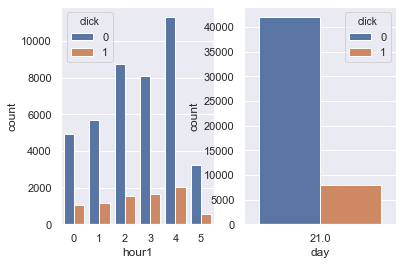

4    13338
2    10297
3     9704
1     6867
0     5995
5     3799
Name: hour1, dtype: int64 21.0    50000
Name: day, dtype: int64


In [36]:
##點擊狀況隨時間變呈常態分配，白天中午較高，點擊與日期無明顯趨勢
fig, axes = plt.subplots(1, 2)
sns.countplot(x="hour1", hue="click",data=train, ax=axes[0])
sns.countplot(x="day", hue="click",data=train,ax =axes[1])
plt.show()
print(train['hour1'].value_counts(),train['day'].value_counts())

In [37]:
tr_ts['day'] = tr_ts['hour'].apply(lambda x: x[-4:-2])
tr_ts['hour'] = tr_ts['hour'].apply(lambda x: x[-2:])

tr_ts['is_device'] = tr_ts['device_id'].apply(lambda x: 0 if x=='a99f214a' else 1)  #針對異常值進行處理


app_id_C_type_dict = json.load(open("app_id_C_type_dict.json", "r"))
site_id_C_type_dict = json.load(open("site_id_C_type_dict.json", "r"))
site_domain_C_type_dict = json.load(open("site_domain_C_type_dict.json", "r"))
device_model_C_type_dict = json.load(open("device_model_C_type_dict.json", "r"))

tr_ts['C_app_id'] = tr_ts["app_id"].apply(lambda x: x if app_id_C_type_dict.get(x)==0 else "other_app_id")
tr_ts['C_site_id'] = tr_ts['site_id'].apply(lambda x: x if site_id_C_type_dict.get(x)==0 else "other_site_id")
tr_ts['C_site_domain'] = tr_ts['site_domain'].apply(lambda x: x if site_domain_C_type_dict.get(x)==0 else "other_site_domain")
tr_ts['C_device_model'] = tr_ts['device_model'].apply(lambda x: x if device_model_C_type_dict.get(x)==0 else "other_device_model")


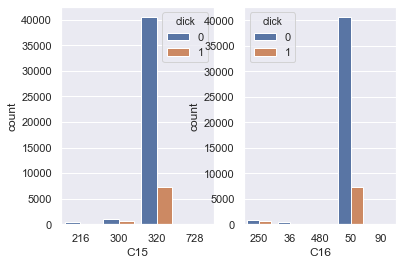

320    47670
300     1781
216      460
728       89
Name: C15, dtype: int64 50     47862
250     1559
36       460
90        89
480       30
Name: C16, dtype: int64


In [38]:
fig, axes = plt.subplots(1, 2)
sns.countplot(x="C15", hue="click",data=train, ax =axes[0])
sns.countplot(x="C16", hue="click",data=train, ax =axes[1])
plt.show()
print(train['C15'].value_counts(),train['C16'].value_counts())

* 特徵組合:將分布相似的兩個特徵進行合併

In [39]:
tr_ts["C_pix"] = tr_ts["C15"] + '&' + tr_ts["C16"]
tr_ts["C_device_type_1"] = tr_ts["device_type"] + '&' + tr_ts["C1"]

tr_ts.drop(['device_id', "device_type", 'app_id', 'site_id', 'site_domain', 'device_model',"C1", "C17", 'C15', 'C16'], axis=1, inplace=True)

In [40]:
#將上述整理的類別變數及原先類別變數進行labelencoder，使類別變數能建立模型
start_time = time.time()
lenc = preprocessing.LabelEncoder()
C_fields = ['hour', 'banner_pos', 'site_category', 'app_domain', 'app_category',
            'device_conn_type', 'C14', 'C18', 'C19', 'C20','C21', 'is_device', 'C_app_id', 'C_site_id', 
            'C_site_domain', 'C_device_model', 'C_pix', 'C_device_type_1']
for f, column in enumerate(C_fields):
    print("convert " + column + "...")
    tr_ts[column] = lenc.fit_transform(tr_ts[column].apply(str))

dummies_site_category = pd.get_dummies(tr_ts['site_category'], prefix = 'site_category')
dummies_app_category = pd.get_dummies(tr_ts['app_category'], prefix = 'app_category')

tr_ts_new = pd.concat([tr_ts, dummies_site_category, dummies_app_category], axis=1)
tr_ts_new.drop(['site_category', 'app_category'], axis = 1, inplace=True)


convert hour...
convert banner_pos...
convert site_category...
convert app_domain...
convert app_category...
convert device_conn_type...
convert C14...
convert C18...
convert C19...
convert C20...
convert C21...
convert is_device...
convert C_app_id...
convert C_site_id...
convert C_site_domain...
convert C_device_model...
convert C_pix...
convert C_device_type_1...


In [43]:
tr_ts_new.iloc[:test.shape[0],].to_csv('train_FE.csv')
tr_ts_new.iloc[test.shape[0]:,].to_csv('test_FE.csv')

In [44]:
##新增其他變數
import csv
from collections import defaultdict

site_id_users = defaultdict(set)
app_id_users = defaultdict(set)

with open(os.path.join(path_raw_data, 'train_FE.csv'), 'r') as csv_file:
    for i, row in enumerate(csv.DictReader(csv_file), start=1):
        site_id_users[row['C_site_id']].add(row['device_ip'])
        app_id_users[row['C_app_id']].add(row['device_ip'])


with open(os.path.join(path_raw_data, 'test_FE.csv'), 'r') as csv_file:
    for i, row in enumerate(csv.DictReader(csv_file), start=1):
        site_id_users[row['C_site_id']].add(row['device_ip'])
        app_id_users[row['C_app_id']].add(row['device_ip'])
        
app_id_dict = pd.Series()
site_id_dict = pd.Series()

for item in app_id_users:
    app_id_dict[item] = int(np.log10(len(app_id_users[item])))

for item in site_id_users:
    site_id_dict[item] = int(np.log10(len(site_id_users[item])))

app_id_dict = app_id_dict.sort_values(ascending=False)
site_id_dict = site_id_dict.sort_values(ascending=False)

app_id_users = app_id_dict.to_dict()
site_id_users = site_id_dict.to_dict()


test  = pd.read_csv(os.path.join(path_raw_data, 'test_FE.csv'), dtype={'id': 'U'}, index_col='id')
train = pd.read_csv(os.path.join(path_raw_data, 'train_FE.csv'), dtype={'id': 'U'}, index_col='id')
tr_ts = pd.concat([test, train], copy=False)

tr_ts['app_id_users'] = tr_ts.C_app_id.apply(lambda x: app_id_users[str(x)] if str(x) in app_id_users else 0)
tr_ts['site_id_users'] = tr_ts.C_site_id.apply(lambda x: site_id_users[str(x)] if str(x) in site_id_users else 0)

C:\Users\sam32564\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\sam32564\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [45]:
import sklearn.preprocessing as preprocessing
# 標準化減少變數間因尺度過大，影響其變數本身重要性
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(tr_ts[['C14','C18','C19','C20','C21']])
tr_ts[['C14','C18','C19','C20','C21']] = age_scale_param.transform(tr_ts[['C14','C18','C19','C20','C21']])

In [46]:
#存檔csv記錄下來
tr_ts.iloc[:test.shape[0],].to_csv('ts_FE.csv')
tr_ts.iloc[test.shape[0]:,].to_csv('tr_FE.csv')

# 4. 特徵篩選-以xgboost模型，調優參數

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score #評估指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
start_time = time.time()

if __name__ == '__main__':

    train = pd.read_csv('tr_FE.csv')
    test = pd.read_csv('ts_FE.csv')
    
    y_train = train.click
    X_train = train.drop(['click', 'device_ip', 'Unnamed: 0'], axis = 1)

    #X_test = loadTestData(testFilePath)

    cv_params = {'n_estimators': [400, 500, 600, 700, 800]}
    other_params = {'learning_rate': 0.1, 
    'n_estimators': 500, 
    'max_depth': 5, 
    'min_child_weight': 1, 
    'seed': 0,
    'subsample': 0.8, 
    'objective' : 'binary:logistic',
    'colsample_bytree': 0.8, 
    'gamma': 0,  
    }
    

    model = xgb.XGBClassifier(**other_params)
    optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
    optimized_GBM.fit(X_train, y_train)
    evalute_result = optimized_GBM.cv_results_

    print('每輪迭代運行結果:{0}'.format(evalute_result))
    print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
    print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
    print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  4.8min finished


每輪迭代運行結果:{'mean_fit_time': array([27.05005155, 33.87526078, 40.4887197 , 47.23134122, 52.90841479]), 'std_fit_time': array([0.06945875, 0.11460418, 0.08412175, 0.09852726, 2.32563021]), 'mean_score_time': array([0.2593821 , 0.31657143, 0.38437753, 0.47187905, 0.57712135]), 'std_score_time': array([0.00765686, 0.00814405, 0.00764776, 0.0062531 , 0.05539917]), 'param_n_estimators': masked_array(data=[400, 500, 600, 700, 800],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 400}, {'n_estimators': 500}, {'n_estimators': 600}, {'n_estimators': 700}, {'n_estimators': 800}], 'split0_test_score': array([-0.39992122, -0.40185395, -0.4034871 , -0.40605893, -0.4080496 ]), 'split1_test_score': array([-0.40137715, -0.40337275, -0.40544902, -0.40708685, -0.4090039 ]), 'split2_test_score': array([-0.39868293, -0.39971222, -0.4010759 , -0.40204727, -0.40359587]), 'split3_test_score': array([-0.40117014, -0.40260056, -

* 調整參數n_estimators

In [4]:
cv_params = {'n_estimators': [350, 375, 400, 425, 450]}

In [6]:
start_time = time.time()

model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.1min finished


每轮迭代运行结果:{'mean_fit_time': array([24.2996191 , 26.21257339, 27.26243434, 28.65943537, 29.5969378 ]), 'std_fit_time': array([0.10106964, 0.17899847, 0.36201621, 0.0535825 , 1.74310577]), 'mean_score_time': array([0.23970428, 0.24765668, 0.25312529, 0.27187033, 0.2656239 ]), 'std_score_time': array([0.00645329, 0.00668109, 0.00624962, 0.00765059, 0.01976691]), 'param_n_estimators': masked_array(data=[350, 375, 400, 425, 450],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 350}, {'n_estimators': 375}, {'n_estimators': 400}, {'n_estimators': 425}, {'n_estimators': 450}], 'split0_test_score': array([-0.39917725, -0.39949935, -0.39992122, -0.40096776, -0.40095076]), 'split1_test_score': array([-0.400145  , -0.40043352, -0.40137715, -0.40184144, -0.40205529]), 'split2_test_score': array([-0.39804854, -0.39824468, -0.39868293, -0.39879608, -0.39889298]), 'split3_test_score': array([-0.40023834, -0.40094339, -

* 調整參數max_depth 和 min_child_weight

In [7]:
cv_params = { 'max_depth':range(3, 10, 2), 'min_child_weight':range(1, 6, 2)}

In [8]:
start_time = time.time()

model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 10.0min finished


每輪迭代運行結果:{'mean_fit_time': array([24.47467799, 24.46879668, 24.43442364, 33.76899076, 33.51471033,
       33.44381542, 43.36520729, 43.03758683, 42.78209562, 53.31860003,
       52.77928815, 51.14735937]), 'std_fit_time': array([0.05334636, 0.03563138, 0.0423877 , 0.10967288, 0.06143605,
       0.19779099, 0.11996628, 0.16874965, 0.15038367, 0.15418604,
       0.17265375, 1.53892052]), 'mean_score_time': array([0.20937543, 0.206249  , 0.20312557, 0.33437595, 0.31562247,
       0.31562939, 0.59687653, 0.56562572, 0.55000205, 1.046878  ,
       0.95937877, 0.86875281]), 'std_score_time': array([7.65654439e-03, 6.24966623e-03, 3.34330523e-06, 2.33844029e-02,
       6.25102710e-03, 6.24744950e-03, 6.25329198e-03, 6.24475815e-03,
       6.25016725e-03, 9.88385234e-03, 7.65333229e-03, 5.97874204e-02]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, Fa

* 調整參數gamma

In [9]:
start_time = time.time()

cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  4.5min finished


每輪迭代運行結果:{'mean_fit_time': array([33.74822125, 33.68195333, 33.63820119, 33.64381714, 33.64069352,
       31.89381523]), 'std_fit_time': array([0.13095351, 0.04237281, 0.1102491 , 0.08350292, 0.11940987,
       2.16559597]), 'mean_score_time': array([0.3156251 , 0.31874905, 0.321877  , 0.31562481, 0.31875124,
       0.29062591]), 'std_score_time': array([0.00624495, 0.00765271, 0.00765512, 0.00624974, 0.00765423,
       0.02538438]), 'param_gamma': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}, {'gamma': 0.6}], 'split0_test_score': array([-0.40198031, -0.40192154, -0.40218596, -0.40197545, -0.40162925,
       -0.40151868]), 'split1_test_score': array([-0.40227433, -0.40308232, -0.40224202, -0.40272055, -0.40224366,
       -0.40290638]), 'split2_test_score': array([-0.40064901, -0.399

* 調整參數subsample、colsample_bytree

In [10]:
start_time = time.time()

cv_params = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 11.0min finished


每輪迭代運行結果:{'mean_fit_time': array([29.96827178, 29.84281106, 29.1276969 , 28.46222758, 32.25647826,
       31.98180699, 31.37631955, 30.63485217, 34.65601521, 34.4014164 ,
       33.69295964, 32.84381423, 37.08008032, 36.65319963, 36.0281929 ,
       35.08132033]), 'std_fit_time': array([0.08409114, 0.0816225 , 0.0600945 , 0.08270332, 0.06574867,
       0.04379435, 0.08385894, 0.09099552, 0.12381828, 0.04966998,
       0.15699574, 0.07460793, 0.07892211, 0.08637871, 0.12079131,
       0.11916436]), 'mean_score_time': array([0.33437543, 0.32812467, 0.32187686, 0.30625424, 0.32812672,
       0.32499948, 0.31249709, 0.31250525, 0.33124967, 0.32500334,
       0.31562381, 0.31250072, 0.32812009, 0.32188077, 0.31875472,
       0.28749862]), 'std_score_time': array([7.65391572e-03, 2.48047005e-06, 7.65130757e-03, 7.65471419e-03,
       3.31530443e-06, 6.24986034e-03, 6.78283049e-06, 3.34126435e-06,
       6.25135958e-03, 6.25131195e-03, 6.24630469e-03, 9.88430440e-03,
       9.88498332e-03, 7.

* 使用正規化參數來調整過度擬合

In [11]:
start_time = time.time()

cv_params = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]} 
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.4min finished


每輪迭代運行結果:{'mean_fit_time': array([33.61113367, 33.64694314, 33.77832813, 33.94698815, 18.96566277]), 'std_fit_time': array([0.0724119 , 0.10392553, 0.08050511, 0.1155703 , 1.13878574]), 'mean_score_time': array([0.31250095, 0.31562505, 0.31875224, 0.32499747, 0.0968791 ]), 'std_score_time': array([5.06211549e-06, 6.24962068e-03, 7.65360714e-03, 6.25207745e-03,
       1.16936228e-02]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([-0.40185392, -0.40230752, -0.4012092 , -0.40280408, -0.40776286]), 'split1_test_score': array([-0.40337272, -0.40266656, -0.40277128, -0.40101309, -0.40453235]), 'split2_test_score': array([-0.3997122 , -0.40113881, -0.40009546, -0.4009064 , -0.40611372]), 'split3_test_score': array([-0.40260053, -0.

* 調整參數learning_rate

In [12]:
start_time = time.time()

cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.9min finished


每輪迭代運行結果:{'mean_fit_time': array([34.23276019, 33.70631857, 33.86568956, 33.762567  , 32.63444419]), 'std_fit_time': array([0.11387705, 0.08232044, 0.17611124, 0.1263211 , 1.94486629]), 'mean_score_time': array([0.31786299, 0.31562629, 0.32187767, 0.31562614, 0.29687166]), 'std_score_time': array([0.0060393 , 0.0062496 , 0.01249836, 0.00625003, 0.02209604]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07, 0.1, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}], 'split0_test_score': array([-0.40025923, -0.39812408, -0.39903399, -0.40185395, -0.41452243]), 'split1_test_score': array([-0.39938134, -0.39825956, -0.399448  , -0.40337275, -0.41495921]), 'split2_test_score': array([-0.39918242, -0.39731104, -0.39881506, -0.39971222, -0.41042953]), 'split3_test_score': array([-0.40059467, -0

In [13]:
start_time = time.time()

cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
model = xgb.XGBClassifier(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_

print('每輪迭代運行結果:{0}'.format(evalute_result))
print('參數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print("It cost %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  3.9min finished


每輪迭代運行結果:{'mean_fit_time': array([34.1829217 , 33.8227509 , 33.84035006, 33.81682453, 32.78437419]), 'std_fit_time': array([0.10363759, 0.0998148 , 0.12419779, 0.10113345, 1.9295186 ]), 'mean_score_time': array([0.31818824, 0.32315516, 0.31882048, 0.32021842, 0.30471048]), 'std_score_time': array([0.00702226, 0.00579307, 0.00074559, 0.00240333, 0.02107869]), 'param_learning_rate': masked_array(data=[0.01, 0.05, 0.07, 0.1, 0.2],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}], 'split0_test_score': array([-0.40025923, -0.39812408, -0.39903399, -0.40185395, -0.41452243]), 'split1_test_score': array([-0.39938134, -0.39825956, -0.399448  , -0.40337275, -0.41495921]), 'split2_test_score': array([-0.39918242, -0.39731104, -0.39881506, -0.39971222, -0.41042953]), 'split3_test_score': array([-0.40059467, -0

# 5. 最終模型及重要特徵

In [14]:
other_params = {
    'learning_rate': 0.05,
    'n_estimators': 400,
    'max_depth': 3,
    'min_child_weight': 3,
    'gamma':0.4,
    'seed': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.6,
    'objective':'binary:logistic',
    'reg_alpha': 0.1,
    'reg_lambda': 1}

             feature  importance
18             C_pix    0.261311
19   C_device_type_1    0.093695
9                C19    0.086824
5       app_category    0.074212
7                C14    0.066439
2         banner_pos    0.058128
4         app_domain    0.052525
0                 id    0.051409
3      site_category    0.050739
8                C18    0.048015
11               C21    0.046418
6   device_conn_type    0.042067
10               C20    0.038750
1               hour    0.029469
12               day    0.000000
13         is_device    0.000000
14          C_app_id    0.000000
15         C_site_id    0.000000
16     C_site_domain    0.000000
17    C_device_model    0.000000
{'C14': 2.383713960450111, 'C19': 3.115116322668929, 'id': 1.844459091076825, 'C_pix': 9.375431505290164, 'hour': 1.0572855346157297, 'site_category': 1.8204430482920142, 'C21': 1.6654120794789569, 'app_category': 2.662608897226751, 'C20': 1.3902744685170714, 'C_device_type_1': 3.3616418134850474, 'device_

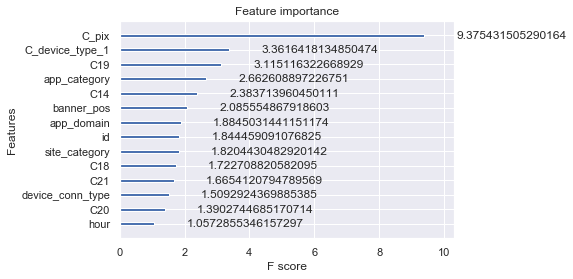

In [15]:
start_time = time.time()

model = xgb.XGBRegressor(n_estimators=350, max_depth=10, objective='binary:logistic', min_child_weight=50,
                         subsample=0.8, gamma=0, learning_rate=0.2, colsample_bytree=0.5, seed=27)

model.fit(X_train, y_train)
# y_test = model.predict(X_test)
xgb.plot_importance(model, importance_type="gain")

features = X_train.columns
feature_importance_values = model.feature_importances_

feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values})

feature_importances.sort_values('importance', inplace=True, ascending=False)
print(feature_importances)

# print(model.get_booster().get_fscore())

print(model.get_booster().get_score(importance_type="gain"))


feature_importances.to_csv('feature.csv')
print("It cost %s seconds" % (time.time() - start_time))

In [114]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  #分類器
from sklearn.metrics import accuracy_score #評估指標
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV     #網格搜尋
import matplotlib.pylab as plt
from sklearn.metrics import f1_score

features = pd.read_csv('feature.csv')
x_columns = features.head(20)['feature'].tolist() #特徵重要性排序，選擇前10名特徵

train = pd.read_csv('tr_FE.csv')

y_train = train.click
X_train = train[x_columns]

X = pd.read_csv('ts_FE.csv', dtype = {'id':'U'})
id_ = X.id
X_ = X[x_columns]


gbm = GradientBoostingClassifier(max_depth=15, learning_rate=0.02, n_estimators=1200, min_samples_leaf=60, 
               min_samples_split =1200, max_features=4, subsample=1.0, random_state=10)

gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_)
y_predprob = gbm.predict_proba(X_)[:,1]

y_out = pd.DataFrame({'id': list(id_), 'click': y_predprob})
y_out.to_csv('y_out1.csv', index = False, sep = ',')  #保存預測值

# 6.評估模型

In [115]:
y_true = np.array(X.click, dtype = int)
try:
    roc_auc_score(y_true, y_pred)
except ValueError:
    pass

In [116]:
#F1score評估約0.5
from sklearn.metrics import f1_score
print("f1score: ", f1_score(y_true, y_pred, average='macro'))

f1score:  0.4994796296721525
